# Scraping top Repositories for topics from GitHub

Web Scraping:
- Web scraping is the automated process of extracting information from websites, typically through software or scripts, to gather data for analysis or other purposes.

GitHub:
- GitHub is a web platform for collaborative coding, offering version control tools to manage code changes and enable teamwork on software projects.

About Project and Project Outline:
- In this project we are to scrape https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we'll get the top 20 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:

```
Username, Repo_name, Stars, Repo_URL
mrdoob, three.js, 69700, https://github.com/mrdoob/three.js
libgdx, libgdx, 18300, https://github.com/libgdx/libgdx
```

Tools used
- Python, requests, Beautiful Soup, pandas

## Scrape the list of topics from GitHub
- using requests to load the page
- use BS4 to parse and extract the info
- converting info to pandas df

Lets write a function to get parsed doc of page

In [1]:
import requests
from bs4 import BeautifulSoup

def web_page_parser(topics_url):
    # returns parsed doc for web page url provided in the input
    response=requests.get(topics_url)
    if response.status_code != 200:
        raise Exception("Unable to access page")
    
    page_content=response.text
    doc = BeautifulSoup(page_content, 'html.parser')
    
    return doc

`web_page_parser` will give us the parsed doc from which we can get further info about website using BS4

In [2]:
doc=web_page_parser("https://github.com/topics")

In [3]:
type(doc)

bs4.BeautifulSoup

In [4]:
doc.find("a")

<a class="px-2 py-4 color-bg-accent-emphasis color-fg-on-emphasis show-on-focus js-skip-to-content" href="#start-of-content">Skip to content</a>

### creating some helper functions to get further info from parsed doc

In [5]:
def get_topic_titles(doc):
    
    topic_title_tags=doc.find_all("p", {"class":"f3 lh-condensed mb-0 mt-1 Link--primary"})

    topic_titles=[]
    for title in topic_title_tags:
        topic_titles.append(title.text)

    return topic_titles


`get_topic_titles` will give us the list of all topic_titles on topic page of GitHub
- to get title we can get `p` tags of `class`:"f3 lh-condensed mb-0 mt-1 Link--primary"
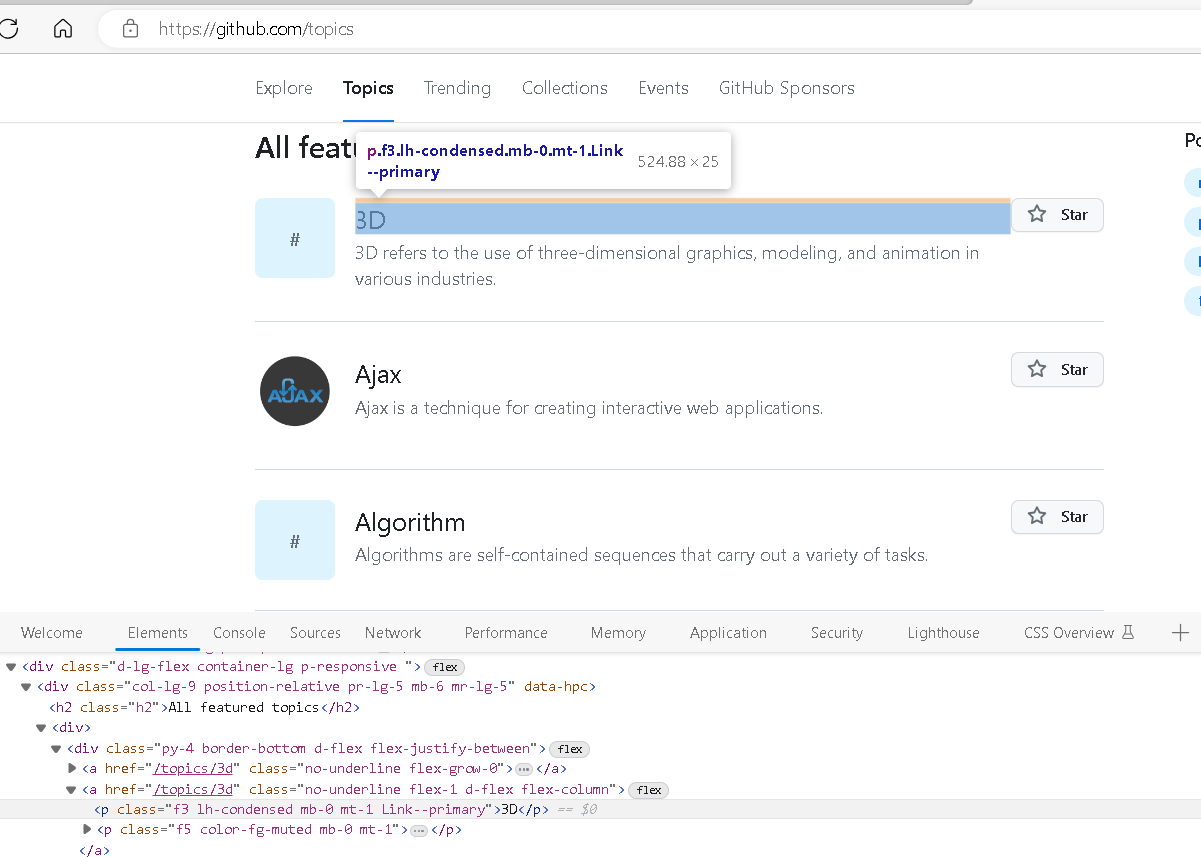

In [6]:
titles=get_topic_titles(doc)

In [7]:
len(titles)

30

In [8]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

### Similarly we have defined functions for getting topic descriptions and URLs

In [14]:
def get_topic_descs(doc):
    # will return the list of topics description for each topic present on that web page
    topic_desc_tags=doc.find_all("p", {"class":"f5 color-fg-muted mb-0 mt-1"})
    
    topic_descs=[]
    for desc in topic_desc_tags:
        topic_descs.append(desc.text.strip())

    return topic_descs


In [15]:
descs=get_topic_descs(doc)

In [12]:
len(descs)

30

In [13]:
descs[:2]

['3D refers to the use of three-dimensional graphics, modeling, and animation in various industries.',
 'Ajax is a technique for creating interactive web applications.']

In [16]:
def get_topic_urls(doc):
    # will return the list of urls for each topic
    topic_link_tags=doc.find_all("a", {"class":"no-underline flex-grow-0"})
    
    topic_urls=[]
    base_url="https://github.com"
    for link in topic_link_tags:
        topic_urls.append(base_url+link["href"])
    return topic_urls

In [17]:
urls=get_topic_urls(doc)

In [18]:
len(urls)

30

In [19]:
urls[:5]

['https://github.com/topics/3d',
 'https://github.com/topics/ajax',
 'https://github.com/topics/algorithm',
 'https://github.com/topics/amphp',
 'https://github.com/topics/android']

## Lets put all these functions together to get topics df

In [21]:
import pandas as pd

def scrape_github_topics(topics_url):
    
    web_page_parser(topics_url)
        
    topics_dict={"title":get_topic_titles(doc),
                 "description":get_topic_descs(doc),
                 "urls":get_topic_urls(doc)
    }
    
    return pd.DataFrame(topics_dict)


#### We have functions to extarct the topic titles, their description and url
`scrape_github_topics` functions puts everything together and returns the df of title, desc and urls

In [22]:
topics_df=scrape_github_topics("https://github.com/topics")
topics_df.head()

,title,description,urls
0,3D,3D refers to the use of three-dimensional grap...,https://github.com/topics/3d
1,Ajax,Ajax is a technique for creating interactive w...,https://github.com/topics/ajax
2,Algorithm,Algorithms are self-contained sequences that c...,https://github.com/topics/algorithm
3,Amp,Amp is a non-blocking concurrency library for ...,https://github.com/topics/amphp
4,Android,Android is an operating system built by Google...,https://github.com/topics/android


## Get top 20 repositories from each topic page
- first we will get the each topic pages
- then we will create helper functions to get info out of those pages
- Finally we will put every thing together and will save the info for each topic CSV files

### function to get to the topic page

In [36]:
def get_topic_page(topic_url):
    #Download the page
    response=requests.get(topic_url)
    
    #checking successful response
    if response.status_code!=200:
        raise Exception("failed to load page {}".format(topic_page_url))
        
    # parsing the page using BeautifulSoup
    topic_doc=BeautifulSoup(response.text, "html.parser")
    return topic_doc

`get_topic_page` will parse the web page and will give us the topic_doc that we will use in further extraction

In [37]:
Ajax_doc=get_topic_page("https://github.com/topics/Ajax")

In [38]:
type(Ajax_doc)

bs4.BeautifulSoup

In [24]:
# Helper function for formatting of star counts
def parse_star_count(star_str):
    #remove the k from star count and multiply it with 1000
    stars=star_str.strip()
    if stars[-1]=="k":
        star_count=int(float(stars[:-1])*1000)
    else:
        star_count=int((stars))
    return star_count

`parse_star_count` function will remove the k from the star count and will simply convert it to proper integer

In [25]:
parse_star_count("23k")

23000

### lets create function for getting complete repo_info


In [26]:
def get_repo_info(h3_tag, star_tag):
    #will return all the required info about repo
    
    a_tags=h3_tag.find_all("a")
    user_name=a_tags[0].text.strip()
    repo_name=a_tags[1].text.strip()
    repo_url=base_url+a_tags[0]["href"]
    no_of_stars=parse_star_count(star_tag.text.strip())
    
    return user_name, repo_name, no_of_stars, repo_url

`get_repo_info` will take h3 and star tag as an input and will return all the required info about the repository
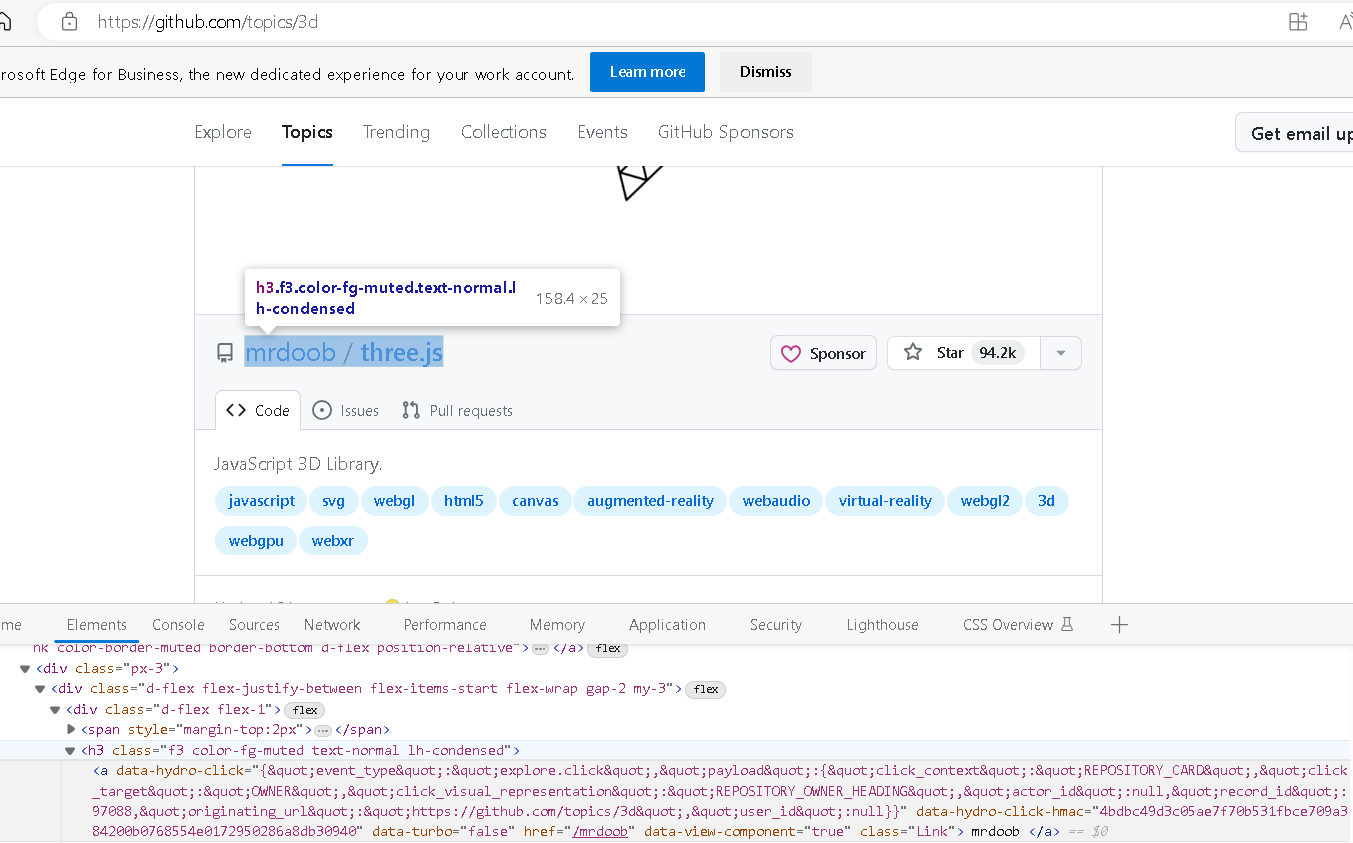

In [41]:
base_url="https://github.com"
Ajax_doc=get_topic_page("https://github.com/topics/Ajax")
repo_tags=Ajax_doc.find_all("h3",{"class":"f3 color-fg-muted text-normal lh-condensed"} )
star_tags=Ajax_doc.find_all("span", {"class":"Counter js-social-count"})

In [42]:
get_repo_info(repo_tags[0],star_tags[0])

('ljianshu', 'Blog', 7700, 'https://github.com/ljianshu')

### Now lets define a function that takes topic_doc as input and returns a df of repo info

In [44]:
def get_topic_repos(topic_doc):
    repo_tags=topic_doc.find_all("h3",{"class":"f3 color-fg-muted text-normal lh-condensed"} )
    star_tags=topic_doc.find_all("span", {"class":"Counter js-social-count"})
    
    # creating dictionary of repo_info
    repo_info_dict={"user_name":[],
               "repo_name":[],
               "no_of_starts":[],
               "repo_url":[]}
    for i in range (len(repo_tags)):
        repo_info=get_repo_info(repo_tags[i], star_tags[i])
        repo_info_dict["user_name"].append(repo_info[0])
        repo_info_dict["repo_name"].append(repo_info[1])
        repo_info_dict["no_of_starts"].append(repo_info[2])
        repo_info_dict["repo_url"].append(repo_info[3])
        
    # returning the pandas df
    return pd.DataFrame(repo_info_dict)

`get_topic_repos` function takes topic doc (provided by `get_topic_page` fucntion and returns df of that repo information

In [46]:
Ajax_doc=get_topic_page("https://github.com/topics/Ajax")
Ajax_df=get_topic_repos(Ajax_doc)
Ajax_df.head()

,user_name,repo_name,no_of_starts,repo_url
0,ljianshu,Blog,7700,https://github.com/ljianshu
1,metafizzy,infinite-scroll,7300,https://github.com/metafizzy
2,olifolkerd,tabulator,5700,https://github.com/olifolkerd
3,developit,unfetch,5600,https://github.com/developit
4,jquery-form,form,5200,https://github.com/jquery-form


In [48]:
import os
def scrape_topic(topic_url, path):
    
    if os.path.exists(path):
        print("The file {} already exists skipping ...".format(path))
        return
    
    topic_doc=get_topic_page(topic_url)
    topics_df=get_topic_repos(topic_doc)
    topics_df.to_csv(path, index=None)

`scrape_topic` is a helper function that will take topic_url and its path as input then uses `get_topic_page` and `get_topic_repos` to get topic df and then save it in csv format

## Putting it all together

- We have a funciton to get the list of topics
- We have a function to create a CSV file for scraped repos from a topics page
- Let's create a function to put them together

In [50]:
def scrape_github_repos():
    print("Scrapping list of topics")
    topics_df=scrape_github_topics("https://github.com/topics")
    os.makedirs("data",exist_ok=True)
    for index,row in topics_df.iterrows():
        print("Scrapping top repositories for {}".format(row["title"]))
        scrape_topic(row["urls"],"data/{}.csv".format(row["title"]))

`scrape_github_repos` will iterate over the DataFrame of topics that contain link of each topic creates a folder named `data` and used `scrape_topic` function to get DataFrame from webpage and then saves it to `data` folder

In [51]:
scrape_github_repos()

Scrapping list of topics
Scrapping top repositories for 3D
The file data/3D.csv already exists skipping ...
Scrapping top repositories for Ajax
The file data/Ajax.csv already exists skipping ...
Scrapping top repositories for Algorithm
The file data/Algorithm.csv already exists skipping ...
Scrapping top repositories for Amp
The file data/Amp.csv already exists skipping ...
Scrapping top repositories for Android
The file data/Android.csv already exists skipping ...
Scrapping top repositories for Angular
The file data/Angular.csv already exists skipping ...
Scrapping top repositories for Ansible
The file data/Ansible.csv already exists skipping ...
Scrapping top repositories for API
The file data/API.csv already exists skipping ...
Scrapping top repositories for Arduino
The file data/Arduino.csv already exists skipping ...
Scrapping top repositories for ASP.NET
The file data/ASP.NET.csv already exists skipping ...
Scrapping top repositories for Atom
The file data/Atom.csv already exists

## Reading a CSV to check wheather evething worked well or not

In [53]:
pd.read_csv("data/3d.csv")

,user_name,repo_name,no_of_starts,repo_url
0,mrdoob,three.js,94100.0,https://github.com/mrdoob
1,pmndrs,react-three-fiber,23600.0,https://github.com/pmndrs
2,libgdx,libgdx,21800.0,https://github.com/libgdx
3,BabylonJS,Babylon.js,21300.0,https://github.com/BabylonJS
4,ssloy,tinyrenderer,17700.0,https://github.com/ssloy
5,lettier,3d-game-shaders-for-beginners,16000.0,https://github.com/lettier
6,aframevr,aframe,15600.0,https://github.com/aframevr
7,FreeCAD,FreeCAD,15000.0,https://github.com/FreeCAD
8,CesiumGS,cesium,10900.0,https://github.com/CesiumGS
9,metafizzy,zdog,10000.0,https://github.com/metafizzy


## References and Future Work

Summary of what we did

- We went to the github website topic section https://github.com/topics and first scraped all the top topics
- Then we went to topic page and extract the info about the top 20 repositories in that topic
- Finally converted all that info in a pandas df and saved saved all that in a csv format

References to links you found useful

- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
 
Ideas for future work

- We can increase the size of data by extracting top 50 or 100 repos
- By running this script time to time we can create as data set by which we can compare the technologies which are emerging 